# Inference

Have a look into the predictions of a certain model on a specific orbit!

In [1]:
import utils.constants as c
import utils.harry_plotter as harry_plotter
import utils.io as io
import utils.training as training
import torch
import torch.nn.functional as F
import yaml

from tqdm.notebook import tqdm
from learning.datasets import MessengerDataset
from torchinfo import summary

In [2]:
MODEL_RUN = 682
ORBIT_ID = 42

Load model checkpoint and hyperparameters

In [3]:
run_path = io.resolve_path(c.RUNS_DIR) / c.RUN_NAME(MODEL_RUN)
state_dict = torch.load(io.resolve_path(run_path) / c.BEST_MODEL_FILE)
with open(run_path / c.HPARAMS_FILE) as f:
    HPARAMS = yaml.load(f, yaml.FullLoader)

Load the specified inference orbit

In [4]:
ds = MessengerDataset(io.resolve_path(c.DATA_DIR),
                      split="eval",
                      features=HPARAMS["features"],
                      window_size=HPARAMS["window_size"],
                      future_size=HPARAMS["future_size"],
                      use_orbits=[ORBIT_ID])

1it [00:00,  3.12it/s]


Reconstruct the model

In [5]:
model = training.construct_model(HPARAMS)
model.load_state_dict(state_dict)
model.eval()

print(model)
summary(model, input_size=(HPARAMS["batch_size"], len(HPARAMS["features"]), HPARAMS["window_size"]), device="cpu")

MLP(
  (flatten): Flatten(start_dim=-2, end_dim=-1)
  (hidden_stack): LinearStack(
    (linear0): Linear(in_features=540, out_features=512, bias=True)
    (relu0): ReLU()
    (batch_norm0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear1): Linear(in_features=512, out_features=350, bias=True)
  )
  (unflatten): Unflatten(dim=-1, unflattened_size=(5, 70))
)


Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      --                        --
├─Flatten: 1-1                           [512, 540]                --
├─LinearStack: 1-2                       [512, 350]                --
│    └─Linear: 2-1                       [512, 512]                276,992
│    └─ReLU: 2-2                         [512, 512]                --
│    └─BatchNorm1d: 2-3                  [512, 512]                1,024
│    └─Linear: 2-4                       [512, 350]                179,550
├─Unflatten: 1-3                         [512, 5, 70]              --
Total params: 457,566
Trainable params: 457,566
Non-trainable params: 0
Total mult-adds (M): 234.27
Input size (MB): 1.11
Forward/backward pass size (MB): 5.63
Params size (MB): 1.83
Estimated Total Size (MB): 8.56

Put all window slices into one large batch

In [6]:
all_windows = torch.stack([sample for sample, label in tqdm(ds)])

  0%|          | 0/43393 [00:00<?, ?it/s]

Classify each time step in each of the windows

In [7]:
pred = model(all_windows)                   # predict class probabilities
pred = pred[:, :, :HPARAMS["window_size"]]  # discard future predictions
pred = pred.flip([2])                       # reverse the time dimension

In [8]:
pred_argmax = pred.argmax(dim=1)                   # select the class with highest probability

In [9]:
pred_avg = F.softmax(pred, dim=1)

In [10]:
labels_avg = torch.tensor([pred_avg.diagonal(dim1=0, dim2=2, offset=i).mean(dim=1).argmax()
                       for i in tqdm(range(pred.shape[2] - 1, -pred.shape[0], -1))])

  0%|          | 0/43452 [00:00<?, ?it/s]

Reduce predictions for each time step to a single one by majority voting

In [11]:
labels_argmax = torch.tensor([pred_argmax.diagonal(dim1=0, dim2=1, offset=i).mode().values
                       for i in tqdm(range(pred.shape[2] - 1, -pred.shape[0], -1))])

  0%|          | 0/43452 [00:00<?, ?it/s]

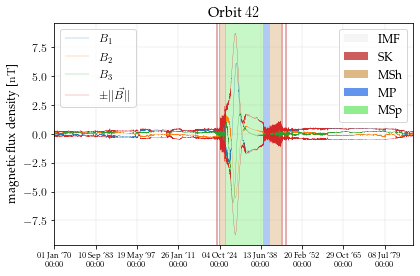

In [12]:
df_orbit = ds.get_orbits()[0]
figpath = str(io.resolve_path(c.TEMP_DIR) / c.MESSENGER(ORBIT_ID)) + "_inference_argmax.pdf"
harry_plotter.plot_orbit(
    df_orbit.index,
    (df_orbit["BX_MSO"],
    df_orbit["BY_MSO"],
    df_orbit["BZ_MSO"]),
    symbol="B",
    labels=labels_argmax,
    title=f"Orbit ${ORBIT_ID}$",
    ylabel="magnetic flux density [\si{nT}]",
    outfile=figpath
)

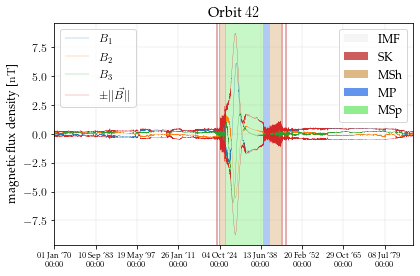

In [13]:
df_orbit = ds.get_orbits()[0]
figpath = str(io.resolve_path(c.TEMP_DIR) / c.MESSENGER(ORBIT_ID)) + "_inference_avg.pdf"
harry_plotter.plot_orbit(
    df_orbit.index,
    (df_orbit["BX_MSO"],
    df_orbit["BY_MSO"],
    df_orbit["BZ_MSO"]),
    symbol="B",
    labels=labels_avg,
    title=f"Orbit ${ORBIT_ID}$",
    ylabel="magnetic flux density [\si{nT}]",
    outfile=figpath
)